# Linear monotone schemes, in two space dimensions

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of PDEs, in two space dimensions. We address both first order and second order problems, but focus on linear equations.

In the second order case, our numerical schemes are adaptive and depend on Selling's decomposition of the diffusion tensors.

*Summary of this series of notebooks:*
[Adaptive grid discretizations, summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/Summary.ipynb)

## 0. Importing the required libraries

In [1]:
import sys; sys.path.append("..") # Allow import from parent directory
from NumericalSchemes import Selling
from NumericalSchemes import LinearParallel as lp
from NumericalSchemes import FiniteDifferences as fd
from NumericalSchemes import AutomaticDifferentiation as ad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg; import scipy.sparse; import scipy.sparse.linalg 

Some utility functions

In [3]:
spid = ad.Sparse.identity

In [5]:
def LInfNorm(a):
    return np.max(np.abs(a))

def as_field(u,shape):
    ndim = len(shape)
    if u.ndim>=ndim and u.shape[-ndim:]==shape: return u
    else: return np.broadcast_to(u.reshape(u.shape+(1,)*ndim), u.shape+shape)
    
def streamplot_ij(X,Y,VX,VY,subsampling=1,*varargs,**kwargs):
    def f(array): return array[::subsampling,::subsampling].T
    return plt.streamplot(f(X),f(Y),f(VX),f(VY),*varargs,**kwargs) # Transpose everything

In [6]:
def reload_packages():
    import importlib
    lp = importlib.reload(sys.modules['NumericalSchemes.LinearParallel'])
    fd = importlib.reload(sys.modules['NumericalSchemes.FiniteDifferences'])
    ad = importlib.reload(sys.modules['NumericalSchemes.AutomaticDifferentiation'])
    ad.Sparse = importlib.reload(ad.Sparse)
    spid = ad.Sparse.identity

## 1. A first order linear equation

We numerically compute the *viscosity* solution of the equation
$$
    1-<\nabla u(x), \omega(x)>=0
$$
over some domain, with Dirichlet boundary conditions.
In general, there exists no classical solution. The viscosity solution therefore has a jump over part of the domain boundary.
In addition, a technical condition is required for the existence of a viscosity solution: the equation
$$
    \gamma'(t) = \omega(\gamma(t)),
$$
solved *backwards in time* from a point $x$, must lead to some point $x_*$ of the domain boundary in finite time $T(x)$. Then 
$$
u(x) = T(x) + b(x_*),
$$
where $b$ denotes the boundary condition.

A monotone numerical scheme for this equation, at a point $x=(x0,x1)$ in the interior of the domain, is 
$$
    1 - \omega_0(x) \frac{u(x_0+h,x_1)-u(x)} h - \omega_1(x) \frac{u(x_0+h,x_1)-u(x)} h= 0,
$$
where with $\omega(x) = (\omega_0(x),\omega_1(x))$ and where we assume that $\omega_0(x)\geq 0$ and $\omega_1(x)\geq 0$.

In [8]:
def Scheme(u,omega,bc,h):
    omega0,omega1 = omega
    residue = 1. - omega0*fd.DiffUpwind(u,(1,0),h) - omega1*fd.DiffUpwind(u,(0,1),h) # 1-<grad u,omega> = 0
    return ad.where(np.isnan(bc),residue,u-bc) # Apply Dirichlet boundary conditions

In [9]:
#Define the square [-1,1]^2, sampled on a cartesian grid
gridScale = 0.04
aX0 = np.arange(-1,1,gridScale); aX1 = aX0
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')
shape = X0.shape

# Define the domain, and the problem parameters
domain = (X0**2+X1**2)<0.9**2
omega = np.stack( (1.3+np.sin(np.pi*X1), np.cos(np.pi*(X0+X1)/4)) )
bc = 0.3*np.sin(2*np.pi*(X0+X1))
bc[domain] = np.nan

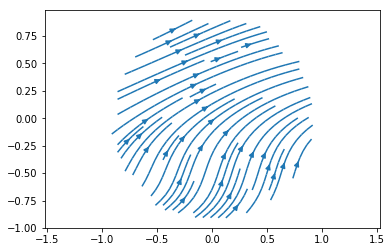

In [10]:
plt.axis('equal')
streamplot_ij(X0, X1, omega[0]*domain, omega[1]*domain);

In [11]:
u = np.zeros(X0.shape) # Initial guess (here zero)
residue = Scheme(u+spid(X0.shape),omega,bc,gridScale)
solution = u + residue.solve()

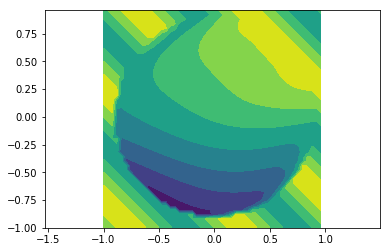

In [12]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

If the vector field $\omega$ does not remain in a fixed quadrant, then the numerical scheme needs to be adaptive, and use upwind finite differences:
$$
    1 - |\omega_0(x)| \frac{u(x_0+s_0(x)h,x_1)-u(x)} h - |\omega_1(x)| \frac{u(x_0+s_1(x)h,x_1)-u(x)} h= 0,
$$
where $s_0(x)$ denotes the sign of $\omega_0(x)$, and likewise for $s_1(x)$.

In [13]:
def Scheme(u,omega,bc,h):
    offset0,offset1 = np.full((2,2)+u.shape,0)
    offset0[0] = np.sign(omega[0])
    offset1[1] = np.sign(omega[1])
    abs_omega0,abs_omega1 = np.abs(omega)
    
    # 1-<grad u,omega> = 0
    residue # = ?? A completer. Utiliser fd.DiffUpwind(u,offset0,h) ...
    
    return ad.where(np.isnan(bc),residue,u-bc) # u-bc=0 on boundary

In [14]:
omega2 = np.stack( (1.3+np.sin(np.pi*X1), np.cos(np.pi*(2*X0+X1)/2)) )

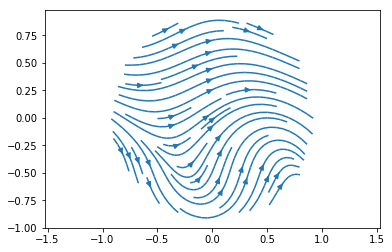

In [15]:
plt.axis('equal')
streamplot_ij(X0,X1,omega2[0]*domain, omega2[1]*domain);

In [16]:
u = spid(X0.shape)
residue = Scheme(u,omega2,bc,gridScale)
solution = residue.solve()

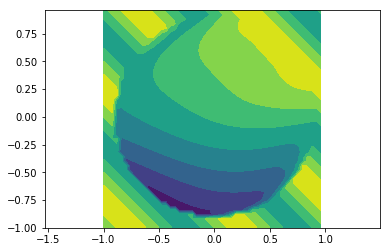

In [17]:
plt.axis('equal')
plt.contourf(X0,X1,solution);

## 2. A second order linear equation

We consider the linear second order equation
$$
    c(x) + m(x) u(x) + <\omega(x),\nabla u(x)> -{\rm tr}(D(x)\nabla^2 u(x)) = 0,
$$
with Dirichlet boundary conditions. For monotony, one needs to assume that $a$ is non-negative, and $D$ is positive semi-definite.

In contrast with the first order examples:
* There exists a classical solution. Hence there is no discontinuity in the viscosity solution.
* We can use a centered finite difference scheme for the first order term, since the it is dominated by the monotony of the second order term.

We use adaptive finite differences, determined by a decomposition of the tensor field
$$
    D(x) = \sum_{1 \leq i \leq n} \mu_i(x) e_i(x) e_i(x)^T,
$$
where $\mu_i(x)$ is non-negative, and $e_i(x)$ has integer offsets.
This induces a decomposition of the vector field
$$
    \omega(x) = \sum_{1 \leq i \leq n} \nu_i(x) e_i(x)
$$
where $\nu_i(x) = \mu_i(x)<D(x)^{-1}\omega(x),e_i(x)>$.
The numerical scheme eventually reads:
$$
    a(x) u(x) 
    + \sum_{1 \leq i \leq n} \nu_i(x) \frac{u(x+h e_i(x))-u(x-h e_i(x))} {2 h} 
    - \sum_{1 \leq i \leq n} \mu_i(x) \frac{u(x+h e_i(x))-2 u(x)+ u(x-h e_i(x))} {h^2}.
$$

In [18]:
def Scheme(u,cst,mult,omega,diff,bc,h):
    """Solve a linear non-divergence form second order PDE"""
    # Decompose the tensor field
    mu,offsets = Selling.Decomposition(diff)
    
    # Decompose the vector field
    nu = mu*lp.dot_VA(lp.solve_AV(diff,omega), offsets.astype(float))
    
    # In interior : cst + mult u + <omega,grad u>- tr(diff hess(u)) = 0 
    mu,nu = (as_field(e,u.shape) for e in (mu,nu))
    residue # A completer. Utiliser nu*fd.DiffCentered(u,offsets,h)).sum(0) ...
    
    # On boundary : u-bc = 0
    return ad.where(np.isnan(bc),residue,u-bc)

Solve a $1-\Delta u = 0$ over a square domain, with null Dirichlet boundary conditions. 
(The mathematician's preferred numerical problem, according to B.M.)

In [19]:
#Define the square [-1,1]^2, sampled on a cartesian grid
gridScale = 0.04
aX0 = np.arange(-1,1,gridScale); aX1 = aX0
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Define the domain, and the problem parameters
cst=1.
mult=0.
omega = np.array((0,0))
diff = np.array( ((1,0),(0,1)) )
bc = np.full(X0.shape,np.nan) # Nothing specified : null boundary conditions outside the domain are by default.

In [20]:
u = spid(X0.shape)
residue = Scheme(u,cst,mult,omega,diff,bc,gridScale)
solution = residue.solve()

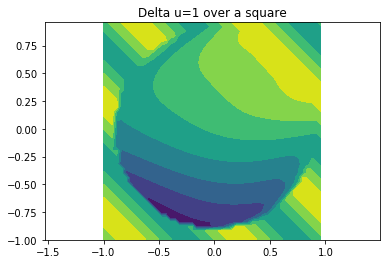

In [21]:
plt.axis('equal'); plt.title("Delta u=1 over a square")
plt.contourf(X0,X1,solution);

### 2.1 Varadhan's formula

We turn to Varadhan's formula for more interesting examples.
First we solve 
$$
    u - \epsilon^2 {\rm tr}(D \nabla^2 u)
$$
with $u(x_0)=1$ at some given point $x_0$, and null boundary conditions on the square boundary. 
Then
$$
    v(x) := -\epsilon \ln u_\epsilon(x)
$$
approximates the Riemmanian distance from $x_0$, for the metric $M:=D^{-1}$ defined by the inverse diffusion tensors.

We reproduce some examples from [I Computing distance maps and geodesics using Varadhan's formulas](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/VaradhanGeodesics.ipynb).
A number of small differences distinguish the implementation presented in that other notebook:
* The laplacian is in divergence form. (Presumably better)
* The boundary conditions are of Neumann type. (Presumably better)
* The numerical scheme is not defined in the notebook, but in an external routine. (Less pedagogical, but presumably faster) 

**Metric specified in terms of eigenvectors and eigenvalues.**
In this example, the metric tensors are specified as 
$$
    M(x) = \lambda_1(x)^{-2} v_1(x) v_1(x)^T + \lambda_2(x)^{-2} v_2(x) v_2(x)^T.
$$
The scalars $\lambda_1$ and $\lambda_2$ appearing in this expression should be regarded as the local velocity in the direction of $v_1$ and $v_2$ respectively.

In [21]:
# Create the domain
gridScale = 0.02
aX0 = np.arange(-1,1,gridScale); aX1=aX0;
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Generate the metric
eig1 = np.stack((np.full(X0.shape,1.),(np.pi/2)*np.cos(2*np.pi*X0)))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

In [22]:
# Relaxation parameter
epsilon=2*gridScale

# Generate the PDE parameters
cst=0.
mult=1.
omega=as_field(np.array([0.,0]),X0.shape)
diff = epsilon**2 * lp.inverse(metric)

bc = np.full(X0.shape,np.nan)
bc[X0.shape[0]//2,X0.shape[1]//2] = 1

In [23]:
u = spid(X0.shape)
residue = Scheme(u,cst,mult,omega,diff,bc,gridScale)
solution = residue.solve()

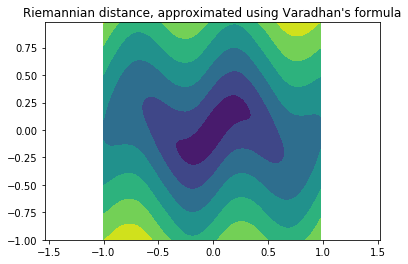

In [24]:
distance = -epsilon*np.log(solution)
plt.axis('equal'); plt.title("Riemannian distance, approximated using Varadhan's formula")
plt.contourf(X0,X1,distance);

**Zermelo's navigation problem.**



In [25]:
# Generate the metric
metric = as_field( np.eye(2), X0.shape)
drift = 0.8*np.sin(2*np.pi*X0)*np.sin(2*np.pi*X1) * np.stack((X0,X1))/ np.sqrt(X0**2+X1**2)
#metric = np.array( ((1,0),(0,1)) ); drift = 0.5*np.array( (1,1) )/np.sqrt(2) # Alternatively : constant drift

In [26]:
# Relaxation parameter
epsilon=3*gridScale

# Generate the PDE parameters
cst=0.
mult=1.
omega=2*epsilon*drift
diff = epsilon**2 * (lp.inverse(metric) - lp.outer_self(drift))

bc = np.full(X0.shape,np.nan)
bc[X0.shape[0]//2,X0.shape[1]//2] = 1

In [27]:
u = spid(X0.shape)
residue = Scheme(u,cst,mult,omega,diff,bc,gridScale)
solution = residue.solve()

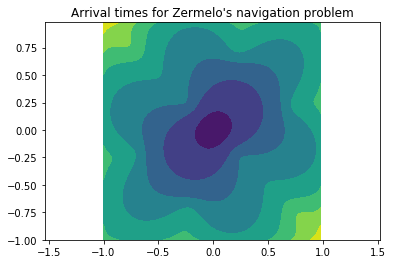

In [28]:
distance = -epsilon*np.log(solution)
plt.axis('equal'); plt.title("Arrival times for Zermelo's navigation problem")
plt.contourf(X0,X1,distance);

In [29]:
grad = np.array(np.gradient(distance,gridScale))
flow = lp.solve_AV(as_field(metric,X0.shape),grad)
flow = flow/np.sqrt(lp.dot_VV(flow,grad)) + as_field(drift,X0.shape)

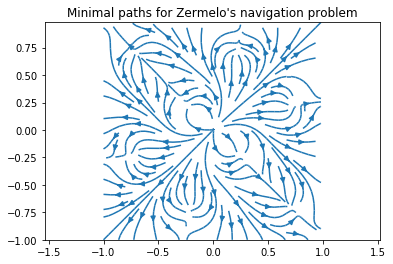

In [30]:
plt.axis('equal'); plt.title("Minimal paths for Zermelo's navigation problem")
streamplot_ij(X0,X1,*flow);